In [4]:
import numpy as np
import h5py
import os
import glob
from nre import io, moco, roi
import ants

from util import _zscore, _zdff

import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

In [15]:
dropboxDir = "/Users/kyle/Library/CloudStorage/Dropbox-ahmedlab/ahmedlab-big/kyle/data"
fly = '231213_106-013'
dataDir = os.path.join(dropboxDir, fly)
nifty_paths_ch1 = glob.glob(os.path.join(dataDir, fly+'_channel_1*.nii'))
nifty_paths_ch2 = glob.glob(os.path.join(dataDir, fly+'_channel_2*.nii'))
nifty_paths_ch1.sort()
nifty_paths_ch2.sort()
print("num ch1 .nii files: ", len(nifty_paths_ch1))
print("num ch2 .nii files: ", len(nifty_paths_ch2))

labels_path = os.path.join(dataDir, fly+'_labels.h5')

num ch1 .nii files:  5
num ch2 .nii files:  5


In [16]:
nii_split_num = 1
splitID = os.path.basename(nifty_paths_ch2[nii_split_num]).split('_')[-1].split('.')[0]

brain = io.load(nifty_paths_ch2[nii_split_num])

n_slices = brain.shape[2]
n_vols = brain.shape[-1]

In [17]:
print("nii split ID: ", splitID)
print("# z slices: ", n_slices)
print("# volumes: ", n_vols)


nii split ID:  s1000
# z slices:  25
# volumes:  500


In [27]:
mean_brain = np.mean(brain, axis=-1)
fixed = ants.from_numpy(mean_brain)

In [29]:
io.save(os.path.join(dataDir, f'fixed_{splitID}.nii'), mean_brain)

In [30]:
moco_brain = np.zeros_like(brain)

for vol in range(n_vols):
    moving = ants.from_numpy(brain[:, :, :, vol])
    moco_brain[:, :, :, vol] = moco.apply(fixed, moving).numpy()

In [31]:
io.save(os.path.join(dataDir, f'moco_brain_{splitID}.nii'), moco_brain)


In [18]:
moco_brain = io.load(os.path.join(dataDir, f'moco_brain_{splitID}.nii'))

In [19]:
moco_brain.shape

(255, 193, 25, 500)

In [20]:
n_clusters = 100  # this can be any number... I suggest 500 or 1000. Brezovec et al used 2000


In [21]:
labels = []

# for each slice in Z, generate n_clusters of pixels and return the pixel label
for iSlice in range(moco_brain.shape[2]):
    cluster_model = roi.create_2d_clusters(moco_brain[:, :, iSlice, :], n_clusters, 'tmp/cluster_mem')
    labels.append(cluster_model.labels_)

In [22]:
F_WINDOW = n_vols

In [23]:
ROIs = np.empty((n_slices, n_clusters, n_vols))

for iSlice in range(n_slices):
    mean_signal = np.empty(shape=(n_vols, n_clusters))

    for vol in range(n_vols):
        mean_supervox, _ = roi.get_supervoxel_mean_2D(moco_brain[:, :, iSlice, vol], labels[iSlice], n_clusters)
        mean_signal[vol] = mean_supervox

    # find zscored(df/f) and smooth over time
    ROIs[iSlice, :, :] = _zdff(mean_signal.T, win=F_WINDOW, smooth=True)

In [24]:
ROIs.shape

(25, 100, 500)

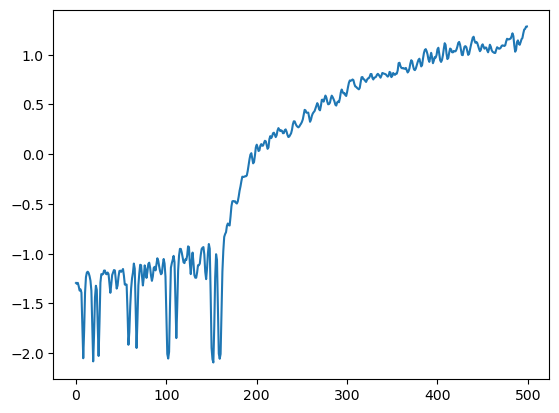

In [35]:
%matplotlib inline
plt.plot(ROIs[6,4,:])
plt.show()